# Exploring Movie Data to Provide Business Recommendations
## Nadya Agrawal
### January 2023


<img src="Images/nicole-kidman-nicole.gif" width="750" align="center">



## The Problem
### Hollywood is highly saturated. How would a newcomer make movies that make money?

Microsoft sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. 

Explore the data to determine what types of films are currently doing the best at the box office. Translate these findings into actionable insights a company like Microsoft can use.

## The Data

### Import the data and packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
conn = sqlite3.connect("zippedData/im.db")
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

When importing from the IMDB dataset, we'll pull out the columns most relevant to our recommendations.

In [2]:
movie_basics = pd.read_sql("""
SELECT primary_title as "movie", start_year as "year", runtime_minutes, genres, primary_name AS "director", primary_profession
  FROM movie_basics as mb
  JOIN directors as d
    ON mb.movie_id= d.movie_id
  JOIN persons as p
    ON d.person_id = p.person_id
""", conn)
movie_gross = pd.read_csv('zippedData/tn.movie_budgets.csv', delimiter = ",")

### Preview the Data

Let's pull up some of the data we just imported. We can see duplicate rows in movie_basics. We'll clean this up later on.

In [3]:
movie_basics.head()

,movie,year,runtime_minutes,genres,director,primary_profession
0,Sunghursh,2013,175.0,"Action,Crime,Drama",Harnam Singh Rawail,"director,writer,producer"
1,Sunghursh,2013,175.0,"Action,Crime,Drama",Harnam Singh Rawail,"director,writer,producer"
2,Sunghursh,2013,175.0,"Action,Crime,Drama",Harnam Singh Rawail,"director,writer,producer"
3,Sunghursh,2013,175.0,"Action,Crime,Drama",Harnam Singh Rawail,"director,writer,producer"
4,One Day Before the Rainy Season,2019,114.0,"Biography,Drama",Mani Kaul,"director,writer,actor"


Interestingly, there are a few movies in our dataframe that haven't come out yet. These will be removed as we go since there won't be monetary information on most of them yet.

In [4]:
movie_basics["year"].value_counts().sort_index()

2010    21891
2011    26687
2012    25622
2013    28931
2014    36654
2015    32079
2016    37229
2017    33439
2018    32488
2019    14391
2020     1565
2021      154
2022       29
2023        6
2024        1
2025        2
2027        2
2115        1
Name: year, dtype: int64

In [5]:
movie_gross.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


### Cleaning the Data

To convert the budget and gross columns, we need to remove the $ and , characters and convert them to integers so we can determine profit. We also want to create a column for the year of release for our next round of analysis.

In [6]:
#removing the dollar signs
movie_gross["production_budget"] = movie_gross["production_budget"].str.replace('$', '')
movie_gross["domestic_gross"] = movie_gross["domestic_gross"].str.replace('$', '')
movie_gross["worldwide_gross"] = movie_gross["worldwide_gross"].str.replace('$', '')

#removing the commas
movie_gross["production_budget"] = movie_gross["production_budget"].str.replace(',', '')
movie_gross["domestic_gross"] = movie_gross["domestic_gross"].str.replace(',', '')
movie_gross["worldwide_gross"] = movie_gross["worldwide_gross"].str.replace(',', '')

#converting to intgers
movie_gross["production_budget"] = movie_gross["production_budget"].astype(int)
movie_gross["domestic_gross"] = movie_gross["domestic_gross"].astype(int)
movie_gross["worldwide_gross"]= movie_gross["worldwide_gross"].astype(int)

#creating column for year of release
movie_gross["year"] = movie_gross["release_date"].apply(lambda x:int(x[-4:]))

In [7]:
movie_gross

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2009
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,2019
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,2015
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017
...,...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,7000,0,0,2018
5778,79,"Apr 2, 1999",Following,6000,48482,240495,1999
5779,80,"Jul 13, 2005",Return to the Land of Wonders,5000,1338,1338,2005
5780,81,"Sep 29, 2015",A Plague So Pleasant,1400,0,0,2015


If we look at the years represented in our datasets, we see that the middle 50 is between 2000 and 2012. The set ranges between 1915 and 2019. It makes the most sense to focus on movies made between 1999 and 2020. That way we include the major clusterings in our dataset and also retain validity since a movie made in the last 20 or so years has more bearing on the movies that are successful today than a movie made before then. So let's remove the rows from before 1999.

In [8]:
movie_gross["year"].describe()

count    5782.000000
mean     2003.967139
std        12.724386
min      1915.000000
25%      2000.000000
50%      2007.000000
75%      2012.000000
max      2020.000000
Name: year, dtype: float64

In [9]:
movie_gross = movie_gross.loc[movie_gross["year"] >= 1999]

We also don't want any rows where "worldwide_gross" or "domestic_gross" is $0 since those are null values and won't help us determine whether this film is profitable or not. Let's see if the number of movies that are missing both those values is the same as the ones missing just one.

In [10]:
movie_gross.loc[(movie_gross["domestic_gross"] == 0) | (movie_gross["worldwide_gross"] == 0)]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year
194,95,"Dec 31, 2020",Moonfall,150000000,0,0,2020
479,80,"Dec 13, 2017",Bright,90000000,0,0,2017
480,81,"Dec 31, 2019",Army of the Dead,90000000,0,0,2019
535,36,"Feb 21, 2020",Call of the Wild,82000000,0,0,2020
617,18,"Dec 31, 2012",AstÃ©rix et ObÃ©lix: Au service de Sa MajestÃ©,77600000,0,60680125,2012
...,...,...,...,...,...,...,...
5761,62,"Dec 31, 2014",Stories of Our Lives,15000,0,0,2014
5764,65,"Dec 31, 2007",Tin Can Man,12000,0,0,2007
5771,72,"May 19, 2015",Family Motocross,10000,0,0,2015
5777,78,"Dec 31, 2018",Red 11,7000,0,0,2018


In [11]:
movie_gross.loc[(movie_gross["domestic_gross"] == 0) & (movie_gross["worldwide_gross"] == 0)]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year
194,95,"Dec 31, 2020",Moonfall,150000000,0,0,2020
479,80,"Dec 13, 2017",Bright,90000000,0,0,2017
480,81,"Dec 31, 2019",Army of the Dead,90000000,0,0,2019
535,36,"Feb 21, 2020",Call of the Wild,82000000,0,0,2020
670,71,"Aug 30, 2019",PLAYMOBIL,75000000,0,0,2019
...,...,...,...,...,...,...,...
5761,62,"Dec 31, 2014",Stories of Our Lives,15000,0,0,2014
5764,65,"Dec 31, 2007",Tin Can Man,12000,0,0,2007
5771,72,"May 19, 2015",Family Motocross,10000,0,0,2015
5777,78,"Dec 31, 2018",Red 11,7000,0,0,2018


Since there are films missing one or both values for "domestic_gross" and "worldwide_gross", we're going to need to first remove all the rows that are missing both these values. Then we'll need to create two different data frames for domestic and worldwide so we don't lose important data. 

mg_clean will be our new dataframe that only contains values that have values for at least one of "domestic_gross" or "worldwide_gross."

In [12]:
mg_clean=movie_gross.loc[(movie_gross["domestic_gross"] != 0) | (movie_gross["worldwide_gross"] != 0)]

Further analysis shows that while some rows are missing domestic_gross, none are missing worldwide_gross. So mg_clean can function as our worldwide_gross dataframe, but we still need a new one for domestic.

In [13]:
mg_clean.loc[mg_clean["domestic_gross"] == 0]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year
617,18,"Dec 31, 2012",AstÃ©rix et ObÃ©lix: Au service de Sa MajestÃ©,77600000,0,60680125,2012
619,20,"Jan 22, 2019",Renegades,77500000,0,1521672,2019
820,21,"Oct 26, 2018",Air Strike,65000000,0,516279,2018
1325,26,"Dec 31, 2012",Foodfight!,45000000,0,73706,2012
1367,68,"Dec 31, 2006",Les BronzÃ©s 3: amis pour la vie,42000000,0,83833602,2006
...,...,...,...,...,...,...,...
5590,91,"Mar 24, 2015",Along the Roadside,250000,0,3234,2015
5652,53,"Dec 31, 2015",Lumea e a mea,168000,0,29678,2015
5661,62,"Dec 31, 2013",Speak No Evil,150000,0,32927,2013
5705,6,"Dec 31, 2011",Absentia,70000,0,8555,2011


In [14]:
mg_clean["worldwide_gross"].value_counts().sort_index()

26            1
176           1
401           1
423           1
450           1
             ..
1518722794    1
1648854864    1
2048134200    1
2053311220    1
2776345279    1
Name: worldwide_gross, Length: 4226, dtype: int64

In [15]:
mgc_w = mg_clean.copy().drop(columns=["id", "domestic_gross"])
mgc_d = mg_clean.loc[mg_clean["domestic_gross"] > 0].drop(columns=["id", "worldwide_gross"])

In [16]:
mgc_w.head()

,release_date,movie,production_budget,worldwide_gross,year
0,"Dec 18, 2009",Avatar,425000000,2776345279,2009
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,1045663875,2011
2,"Jun 7, 2019",Dark Phoenix,350000000,149762350,2019
3,"May 1, 2015",Avengers: Age of Ultron,330600000,1403013963,2015
4,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,1316721747,2017


In [17]:
mgc_d.head()

,release_date,movie,production_budget,domestic_gross,year
0,"Dec 18, 2009",Avatar,425000000,760507625,2009
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,2011
2,"Jun 7, 2019",Dark Phoenix,350000000,42762350,2019
3,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,2015
4,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,2017


Now it's time to create new columns for profits (gross - budget), divide them by 1,000,000 to get more usable numbers, and remove the gross columns.

In [18]:
#making a column for profits
mgc_w["worldwide_profits"] = mgc_w["worldwide_gross"] - mgc_w["production_budget"]
mgc_d["domestic_profits"] = mgc_d["domestic_gross"] - mgc_d["production_budget"]


#dividing by a million
mgc_w["worldprofits_inmillions"] = mgc_w["worldwide_profits"] / 1000000
mgc_d["domesticprofits_inmillions"] = mgc_d["domestic_profits"]/ 1000000

#removing gross columns
mgc_w=mgc_w.drop(columns = ["worldwide_gross", "worldwide_profits", "production_budget"])
mgc_d=mgc_d.drop(columns = ["domestic_gross", "domestic_profits", "production_budget"])

We're going to merge our data frames movie_basics from IMDB and movie_gross from The Numbers along "movie" for "year" to create the new dataframes for worldwide and domestic profits. We'll also remove rows that are missing values for profits in each of these dataframes.

In [19]:
mgcw_totals = pd.merge(mgc_w, movie_basics, on = ["movie", "year"], how = "outer").dropna(subset =["worldprofits_inmillions"]).drop_duplicates()
mgcd_totals = pd.merge(mgc_d, movie_basics, on = ["movie", "year"], how = "outer").dropna(subset =["domesticprofits_inmillions"]).drop_duplicates()

In [20]:
mgcw_totals.sort_values("worldprofits_inmillions")

,release_date,movie,year,worldprofits_inmillions,runtime_minutes,genres,director,primary_profession
6,"Jun 7, 2019",Dark Phoenix,2019,-200.237650,113.0,"Action,Adventure,Sci-Fi",Simon Kinberg,"producer,writer,director"
733,"Mar 11, 2011",Mars Needs Moms,2011,-110.450242,88.0,"Adventure,Animation,Family",Simon Wells,"animation_department,director,art_department"
1135,"Jun 14, 2019",Men in Black: International,2019,-106.900000,115.0,"Action,Adventure,Comedy",F. Gary Gray,"director,actor,producer"
1156,"Apr 27, 2001",Town & Country,2001,-94.635231,NaN,NaN,NaN,NaN
1259,"Aug 16, 2002",The Adventures of Pluto Nash,2002,-92.905005,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
148,"Jun 12, 2015",Jurassic World,2015,1433.854864,124.0,"Action,Adventure,Sci-Fi",Colin Trevorrow,"writer,producer,director"
18,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,2015,1747.311220,NaN,NaN,NaN,NaN
31,"Apr 27, 2018",Avengers: Infinity War,2018,1748.134200,149.0,"Action,Adventure,Sci-Fi",Joe Russo,"producer,director,writer"
19,"Apr 27, 2018",Avengers: Infinity War,2018,1748.134200,149.0,"Action,Adventure,Sci-Fi",Anthony Russo,"producer,director,writer"


In [21]:
mgcd_totals.sort_values("domesticprofits_inmillions")

,release_date,movie,year,domesticprofits_inmillions,runtime_minutes,genres,director,primary_profession
6,"Jun 7, 2019",Dark Phoenix,2019,-307.237650,113.0,"Action,Adventure,Sci-Fi",Simon Kinberg,"producer,writer,director"
69,"Mar 9, 2012",John Carter,2012,-201.941321,132.0,"Action,Adventure,Sci-Fi",Andrew Stanton,"writer,actor,producer"
66,"Jul 2, 2013",The Lone Ranger,2013,-185.697885,150.0,"Action,Adventure,Western",Gore Verbinski,"director,producer,writer"
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,2011,-169.536125,136.0,"Action,Adventure,Fantasy",Rob Marshall,"director,miscellaneous,producer"
142,"May 18, 2012",Battleship,2012,-154.766600,131.0,"Action,Adventure,Sci-Fi",Peter Berg,"producer,actor,writer"
...,...,...,...,...,...,...,...,...
129,"May 4, 2012",The Avengers,2012,398.279547,143.0,"Action,Adventure,Sci-Fi",Joss Whedon,"writer,producer,director"
167,"Jun 15, 2018",Incredibles 2,2018,408.581744,118.0,"Action,Adventure,Animation",Brad Bird,"miscellaneous,writer,director"
148,"Jun 12, 2015",Jurassic World,2015,437.270625,124.0,"Action,Adventure,Sci-Fi",Colin Trevorrow,"writer,producer,director"
163,"Feb 16, 2018",Black Panther,2018,500.059566,134.0,"Action,Adventure,Sci-Fi",Ryan Coogler,"director,writer,producer"


Now we have a clean pair of dataframes that tell us release date, movie, year of release, profits, runtime, genres, director, and director profession for both worldwide profits and domestic profits. We are missing some values in some of the columns but we'll need to remove these later as needed. It's time to move on to the analysis.

# The Analysis
## When should Microsoft release movies?

Movies are released at key points throughout the year – the summer blockbuster, the Christmas family flick. The time of year a movie is released might be critical to its profitability.

Let's start by creating new data frames that include month columns which add a month number based on the "release_date" column. Then we'll remove unneeded columns and group each dataframe by the average profits.

In [22]:
#adding a months column for our worldwide dataframe and removing unneded columns
month_w = mgc_w.copy()
month_w['month'] = pd.to_datetime(month_w['release_date']).dt.month
month_w = month_w.drop(columns=["release_date", "movie", "year"])
month_w = month_w.groupby("month").mean().reset_index()

#adding a months column for our domestic dataframe and removing unneded columns
month_d = mgc_d.copy()
month_d['month']=pd.to_datetime(month_d['release_date']).dt.month
month_d=month_d.drop(columns=["release_date", "movie", "year"])
month_d=month_d.groupby("month").mean().reset_index()

Now we can map the relationship between month of release and profits.

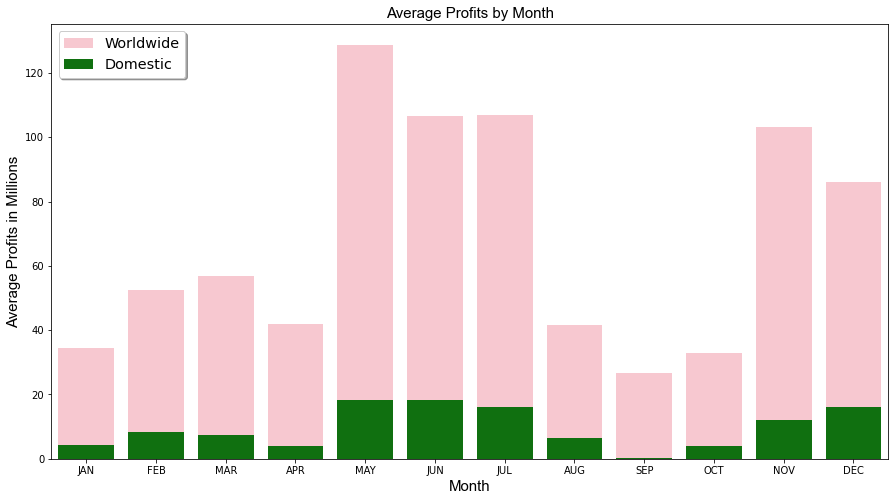

In [23]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=month_w["month"], y=month_w["worldprofits_inmillions"], color='pink', label='Worldwide', ci = None)
ax = sns.barplot(x=month_d["month"], y=month_d["domesticprofits_inmillions"], color='green', label= 'Domestic', ci = None)
ax.set_xlabel('Month', fontfamily = 'Arial', fontsize = 15)
ax.set_ylabel('Average Profits in Millions', fontfamily = 'Arial', fontsize = 15)
ax.set_title('Average Profits by Month', fontfamily = 'Arial', fontsize = 15)
ax.set_xticklabels(['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'])
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')

### For both world and domestic releases, Microsoft should release its movies in May, June, July, November, or December. September is the worst month for a movie release.

### Also, worldwide release profits are considerably higher than movies that are just released domestically.

## What genres should Microsoft focus on?

There are so many types of films a studio can make. From action to musical, there are so many options and combinations of genres that can yield profits. Which genres are the most profitable?

To get genre information, we need to go back to our old totals dataframe and remove all rows where genre isn't listed. Also, it's clear in our month of release analysis that worldwide releases make way more than movies that are only released domestically. Moving forward, we'll focus only on worldwide releases since they're the most strategic releases for Microsoft.

In [24]:
mgcw_totals

,release_date,movie,year,worldprofits_inmillions,runtime_minutes,genres,director,primary_profession
0,"Dec 18, 2009",Avatar,2009,2351.345279,NaN,NaN,NaN,NaN
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,2011,635.063875,136.0,"Action,Adventure,Fantasy",Rob Marshall,"director,miscellaneous,producer"
6,"Jun 7, 2019",Dark Phoenix,2019,-200.237650,113.0,"Action,Adventure,Sci-Fi",Simon Kinberg,"producer,writer,director"
12,"May 1, 2015",Avengers: Age of Ultron,2015,1072.413963,141.0,"Action,Adventure,Sci-Fi",Joss Whedon,"writer,producer,director"
17,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,2017,999.721747,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
7311,"May 26, 2006",Cavite,2006,0.064644,NaN,NaN,NaN,NaN
7312,"Dec 31, 2004",The Mongol King,2004,-0.006100,NaN,NaN,NaN,NaN
7313,"Apr 2, 1999",Following,1999,0.234495,NaN,NaN,NaN,NaN
7314,"Jul 13, 2005",Return to the Land of Wonders,2005,-0.003662,NaN,NaN,NaN,NaN


In [25]:
genres_w = mgcw_totals.dropna(subset=["genres"])

In some cases, our genres are clustered together. Let's separate them.

In [26]:
#for worldwide profits
genres_w["genres"] = genres_w["genres"].apply(lambda x: str(x).split(","))
genres_w = genres_w.explode('genres')
genres_w = genres_w.groupby("genres").mean().reset_index()
genres_w = genres_w.sort_values(by=["worldprofits_inmillions"], ascending = False)

Now we can map the relationship between genre and profits for both world releases.

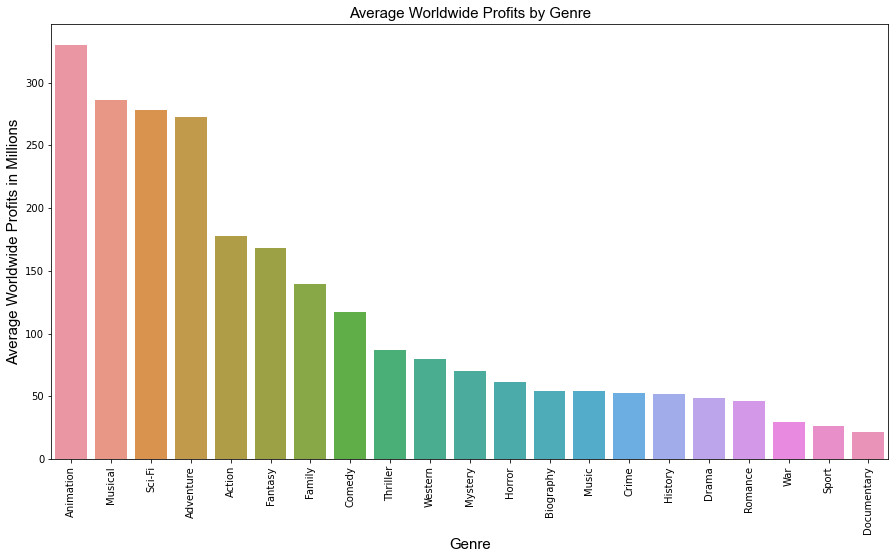

In [27]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=genres_w["genres"], y=genres_w["worldprofits_inmillions"], ci = None)
ax.set_xlabel('Genre', fontfamily = 'Arial', fontsize = 15)
ax.set_ylabel('Average Worldwide Profits in Millions', fontfamily = 'Arial', fontsize = 15)
ax.set_title('Average Worldwide Profits by Genre', fontfamily = 'Arial', fontsize = 15)
plt.xticks(rotation=90);

### Animation, Musical, Sci-Fi, Adventure, and Action are the highest earning genres (in that order).

## How long should Microsoft's Movies Be?

Movies range in time, usually determined by genre. Short, 90 minute films are great for kids and family films while Marvel action releases tend to be two hours or longer. 

If we focus on our most profitable genres, we can find what the most typical runtimes for each one should be. We'll use Animation, Musical, Sci-Fi, Adventure, and Action for our analysis.

In [28]:
#create new dataframe for genres
rt_genresw = mgcw_totals.dropna(subset=["genres"])

#split genre clusters
rt_genresw["genres"] = rt_genresw["genres"].apply(lambda x: str(x).split(","))
rt_genresw = rt_genresw.explode("genres")
rt_genresw = rt_genresw.sort_values(by=["genres"])

#narrow down to top-performing genres
rt_genresw = rt_genresw.loc[(rt_genresw["genres"] == "Animation") | (rt_genresw["genres"] == "Adventure") | 
                          (rt_genresw["genres"] == "Sci-Fi") | (rt_genresw["genres"] == "Action" )|
                         (rt_genresw["genres"] == "Musical")]

#remove rows that don't have runtimes listed
rt_genresw = rt_genresw.dropna(subset = ["runtime_minutes"])

#focus on where movies typically fall in runtime
rt_genresw = rt_genresw.loc[(rt_genresw["runtime_minutes"] >= 74) & (rt_genresw["runtime_minutes"] <= 174)]

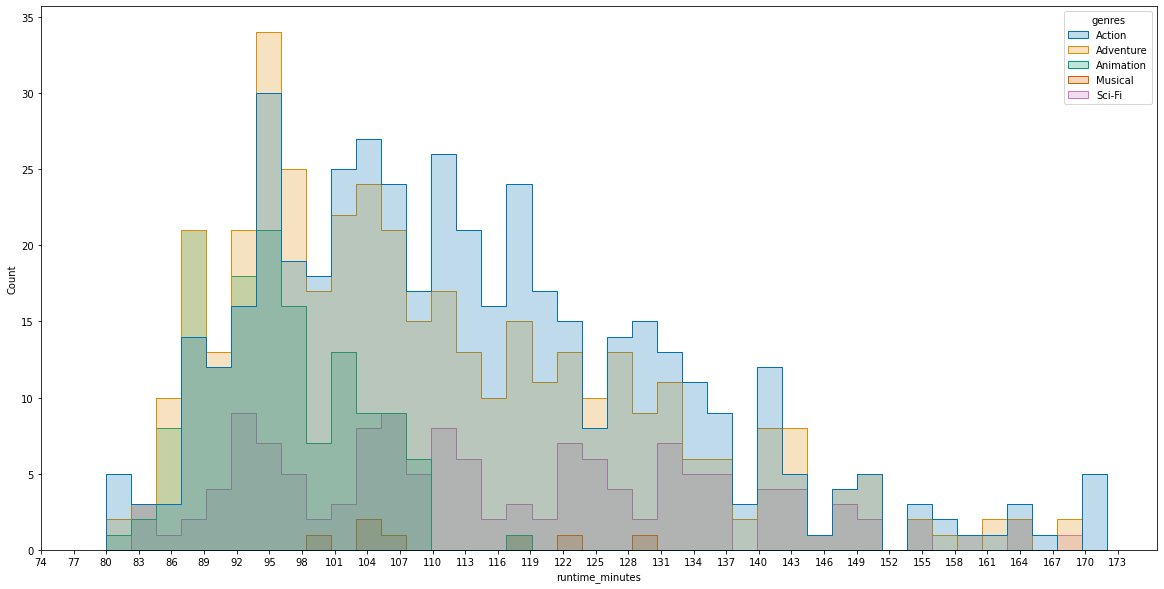

In [29]:
plt.figure(figsize=(20,10))
sns.set_palette("colorblind")
g = sns.histplot(data=rt_genresw, x="runtime_minutes", hue = "genres", element="step", bins = 40)
g.set_xticks(range(74, 174, 3))
plt.show()

### Action and adventure films can go as long as 2.5 hours, but they peak around 95 minutes.

### Animation can be as short as 80 minutes but should not exceed 110. 95 minutes is ideal.

### Musicals should be near 104 minutes.

### Sci-Fi movies should be on the longer side between 110-155 minutes.

## Which director should Microsoft hire to make their movies?

A good film comes down to story, cinematography, and style. But the names attached to a movie also matter – famous directors can pull huge audiences. Consistent directors who routinely bring in millions are pretty good predictors of the success of a film. It would be useful for Microsoft to know which directors have the highest ROI for worldwide releases – if you give them x amount of money, the're likely to bring in y dollars.

We'll focus on our most profitable genres to find the directors with greatest ROI for each one. We can go back to our mg_clean data frame since it contains all our monetary data. We can't use the worldprofits frame we created since we're going to create an ROI column based on production budget and gross. We'll combine this with our movie_basics dataframe again to get key information about directors.

In [30]:
#merge tables and remove unneded columns
clean_totals = pd.merge(mg_clean, movie_basics, on = ["movie", "year"], how = "outer").drop_duplicates()
directors_roi = clean_totals.drop(columns = ["id", "release_date", "movie", "domestic_gross", "year",
                                           "runtime_minutes"])
#make "roi" column
directors_roi["roi"] = ((directors_roi["worldwide_gross"] - directors_roi["production_budget"])/ directors_roi["production_budget"]) * 100

#remove production_budget and worldwide_gross columns
directors_roi = directors_roi.drop(columns = ["production_budget", "worldwide_gross"])

#separate genres
directors_roi["genres"] = directors_roi["genres"].apply(lambda x: str(x).split(","))
directors_roi = directors_roi.explode('genres')

#remove rows missing data for ROI and director, remove rows that do not contain directors
directors_roi = directors_roi.dropna(subset = ["roi", "director"])
directors_roi = directors_roi[directors_roi["primary_profession"].str.contains("director")==True]
directors_roi = directors_roi.drop(columns=["primary_profession"])

#sort by genre
directors_roi = directors_roi.sort_values(by=["genres", "roi"], ascending = False)


Now, we'll divide our data frame out by genre and then concat them for graphing.

In [31]:
#focus on top-earning genres
top_directors = directors_roi.loc[(directors_roi["genres"] == "Action") | (directors_roi["genres"] == "Adventure") |
                                 (directors_roi["genres"] == "Animation") | (directors_roi["genres"] == "Musical") |
                                 (directors_roi["genres"] == "Sci-Fi")]

#make separate dataframes for these genres
topaction_directors = directors_roi.loc[directors_roi["genres"] == "Action"].groupby(["director", "genres"]).mean().reset_index().sort_values(by=["roi"], ascending=False).head(3)
topadventure_directors = directors_roi.loc[directors_roi["genres"] == "Adventure"].groupby(["director", "genres"]).mean().reset_index().sort_values(by=["roi"], ascending=False).head(3)
topanimation_directors = directors_roi.loc[directors_roi["genres"] == "Animation"].groupby(["director", "genres"]).mean().reset_index().sort_values(by=["roi"], ascending=False).head(3)
topmusical_directors = directors_roi.loc[directors_roi["genres"] == "Musical"].groupby(["director", "genres"]).mean().reset_index().sort_values(by=["roi"], ascending=False).head(3)
topscifi_directors = directors_roi.loc[directors_roi["genres"] == "Sci-Fi"].groupby(["director", "genres"]).mean().reset_index().sort_values(by=["roi"], ascending=False).head(3)

#concat these new dataframes into one, top_directors
top_directors = pd.concat([topaction_directors, topadventure_directors, topanimation_directors, topmusical_directors, 
                          topscifi_directors], join = "outer")
top_directors


,director,genres,roi
211,Nitesh Tiwari,Action,3001.627558
281,Tim Miller,Action,1281.078609
118,James DeMonaco,Action,1112.211863
153,Kyle Balda,Adventure,1373.829428
196,Pierre Coffin,Adventure,1310.279634
247,Tim Miller,Adventure,1281.078609
47,Kyle Balda,Animation,1373.829428
59,Pierre Coffin,Animation,1154.617179
81,Yarrow Cheney,Animation,1082.334045
2,Bill Condon,Musical,686.999816


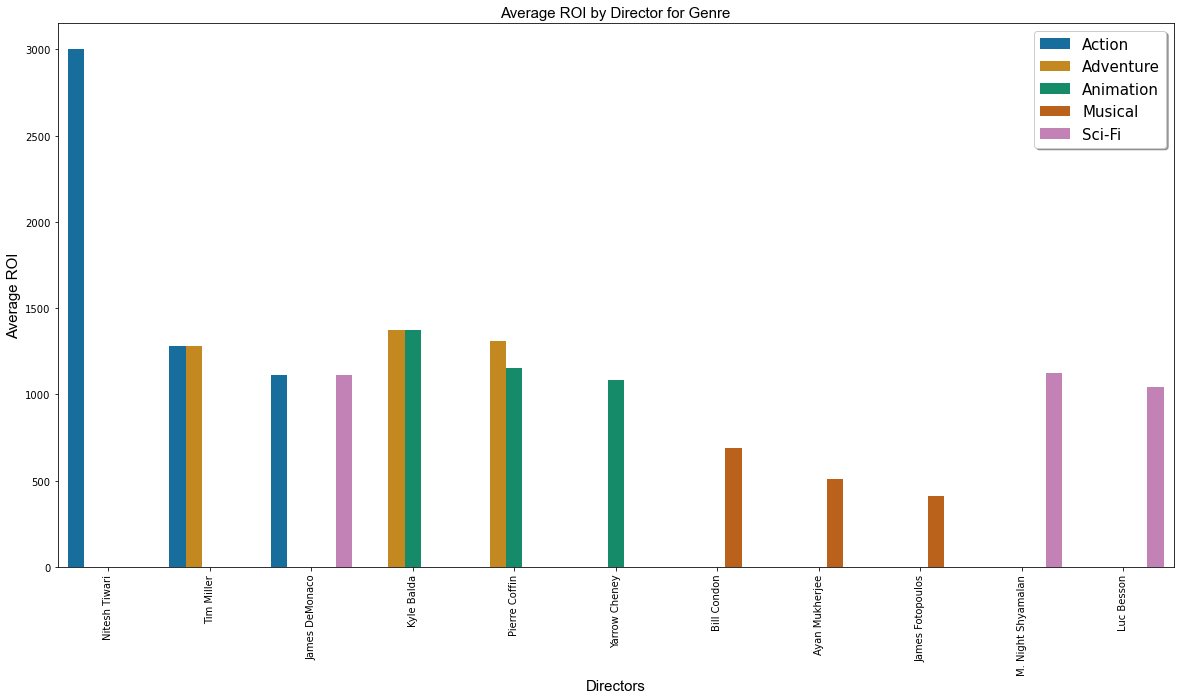

In [32]:
plt.figure(figsize=(20,10))
ax = sns.barplot(data = top_directors, x= "director", y= "roi", hue = "genres", ci = None)
ax.set_xlabel('Directors', fontfamily = 'Arial', fontsize = 15)
ax.set_ylabel('Average ROI', fontfamily = 'Arial', fontsize = 15)
ax.set_title('Average ROI by Director for Genre', fontfamily = 'Arial', fontsize = 15)
legend = ax.legend(loc='upper right', shadow=True, fontsize = 15)
plt.xticks(rotation=90);
plt.show()

### Based on the above visualization, Microsoft should hire Nitesh Tiwari for action films, Kyle Balda for adventure and/or animated films, Bill Condon for musicals, and M. Night Shyamalan for science fiction.

## Recommendations 

In summary, the data shows Microsoft should do the following to maximize profits:

 - __Focus on worldwide releases.__
 - __Release movies in May, June, July, November, and December. DO NOT release in September.__
 - __Release action, adventure, animation, musical, and/or sci-fi films.__
 - __Hire directors Nitesh Tiwari for action films, Kyle Balda for adventure and/or animated films, Bill Condon for musicals, and M. Night Shyamalan for science fiction.¶.__

## Next Steps

1. __Update the data with more recent information.__ The vast majority of the data we used is from 2019 or before. Recently successful films are better indicators of future successful films. The pandemic as well majorly influenced cinema-attendance trends with a move towards home streaming for new releases. To continue making recommendations, we need to understand how people are watching movies now.

2. __Consider marketing and branding.__ Some of the most successful films in our dataset come from movie franchises like Fast & Furious, major brands like Marvel and Disney, and have highly expansive digital and media advertising strategy attached. It's worth looking at how advertising and brand recognition come together to determine profitability.

3. __Determine the brand niche.__ While a lot of the analysis above is centered around maximizing profits, it's clear to see that the current marketplace for movies is overcrowded with superhero films, high-budget CGI productions, and movies that generally require high investment for high reward. It is worth considering whether a brand like Microsoft can make a niche in one genre, like Horror, Thriller, or Video Game Adaptations, or via a medium like streaming, or within a smaller production budget range.